# Libraries

In [753]:
import numpy as np
from termcolor import colored

# Enviroment Traffic

In [754]:
# Reinforcement Learning Markov decission process
import random
from typing import Literal
import itertools


def shift_numbers(numbers: list):
    """
    Shifts the numbers in the list to the left by one position
    """
    return numbers[1:] + [0]


def push_ones(numbers: list):
    """
    Push ones to the left
    (1,0,1,1) = (1,1,1,0)
    """

    for i in range(len(numbers)):
        if numbers[i] == 0:
            new_values = shift_numbers(numbers[i:])
            for j in range(len(new_values)):
                numbers[i + j] = new_values[j]
            break

    return numbers


class Traffic_Enviroment:
    def __init__(self, left, up, pL=0.35, pU=0.35) -> None:
        self.left = left
        self.up = up
        self.pL = pL
        self.pU = pU

        self.n_cars_left = 0
        self.n_cars_up = 0
        self.TL_values = ("g", "r")
        self.goal = int(left / 2) + int(up / 2)  # cantidad de carros esperada

        # actions
        self.actions = ("g", "r")

        # states
        # ([0]x(left+up), TL_values)
        self.states = self.generate_all_combinations()
        self.state = self.states[-1]

    # All combinatories  # ([value]x(left+up), TL_values)
    def generate_all_combinations(self) -> list:
        # Generate all combinations of 0 and 1 for 3 traffic lights
        combinations = itertools.product([0, 1], repeat=self.left + self.up)
        # Initialize an empty list to store the final combinations
        final_combinations = []
        # For each combination, append 'g' and 'r' to create two new tuples
        for combination in combinations:
            final_combinations.append(combination + ("g",))
            final_combinations.append(combination + ("r",))
        return final_combinations

    # 'g' pass the left, 'r' pass the up

    def reset(self):
        self.state = self.states[-1]

    def change(self, state: tuple, action: str, add_left=False, add_up=False) -> tuple:
        left = list(self.get_left(state))
        up = list(self.get_up(state))

        if action == "g":
            left = shift_numbers(left)
            up = push_ones(up)
        else:
            up = shift_numbers(list(self.get_up(state)))
            left = push_ones(left)
        if add_left:
            left[-1] = 1
        if add_up:
            up[-1] = 1
        return tuple(left + up + [action])

    def reward(self, state: tuple, action: str):
        next_state = self.change(state, action)

        if self.count_zeros(list(next_state[:-1])) >= self.goal:
            return 0
        return -1

    def nextState(self, state: tuple, action: str):
        nextStates = {}
        next_state = self.change(state, action)
        # TODO
        # if self.count_ones(list(next_state[:-1])) <= self.goal:
        #     nextStates[next_state] = 1.0
        #     return nextStates

        if action == "g":
            nextStates[next_state] = self.pL
            nextStates[self.change(state, "g", True)] = (1 - self.pL) / 3
            nextStates[self.change(state, "g", True, True)] = (1 - self.pL) / 3
            nextStates[self.change(state, "g", False, True)] = (1 - self.pL) / 3

        else:
            nextStates[next_state] = self.pU
            nextStates[self.change(state, "r", True)] = (1 - self.pU) / 3
            nextStates[self.change(state, "r", True, True)] = (1 - self.pU) / 3
            nextStates[self.change(state, "r", False, True)] = (1 - self.pU) / 3
        return nextStates

    def simulateStep(self, state, action):
        reward = self.reward(state, action)
        nextStates = self.nextState(state, action)
        return (
            random.choices(
                list(nextStates.keys()), weights=list(nextStates.values()), k=1
            )[0],
            reward,
        )

    def step(self, action: Literal["g", "r"]):
        self.state, reward = self.simulateStep(self.state, action)
        return self.state, reward

    # Render the cars, traffic light, etc
    def render(self):
        for row in range(self.left + 1):
            for col in range(self.up + 1):
                if row == self.left and col == self.up:
                    if self.state[-1] == "g":
                        print(colored("G", "green"), end=" ")
                    else:
                        print(colored("R", "red"), end=" ")
                elif row == self.left:
                    if self.get_left(self.state)[abs(col - self.left + 1)] == 1:
                        print(colored("L", "blue"), end=" ")
                    else:
                        print(colored("-", "blue"), end=" ")
                elif col == self.up:
                    if self.get_up(self.state)[abs(row - self.up + 1)] == 1:
                        print(colored("U", "blue"), end=" ")
                    else:
                        print(colored("-", "blue"), end=" ")
                else:
                    print("*", end=" ")
            print()

    def get_left(self, state: tuple):
        return state[: self.left]

    def get_up(self, state: tuple):
        return state[self.up : -1]

    def get_tl(self, state: tuple):
        return state[-1]

    def count_zeros(self, numbers: list):
        return numbers.count(0)

# Policy Evaluation

## Policy Iteration

In [768]:
import numpy as np
import matplotlib.pyplot as plt

def policy_evaluation(Environment,pi, gamma, epsilon):
    V = {}
    for s in Environment.states:
        V[s] = 0

    res = float('inf')

    while res > epsilon:
        V_old = V.copy()
        res = 0

        for s in Environment.states:
            V[s] = Environment.reward(s,pi[s])
            Transitions = Environment.nextState(s,pi[s])
            for ss in Transitions:
                V[s] = V[s] + gamma*Transitions[ss]*V_old[ss]

            if abs(V[s] - V_old[s]) > res:
                res = abs(V[s] - V_old[s])

    return V

def policy_improvement(Environment,V, gamma):
    pi = {}
    for s in Environment.states:
        Q = {}
        for a in Environment.actions:
            Q[a] = Environment.reward(s,a)
            Transitions = Environment.nextState(s,a)
            for ss in Transitions:
                Q[a] = Q[a] + gamma*Transitions[ss]*V[ss]

        pi[s] = max(Q, key=Q.get)
    return pi

def policy_iteration(Environment, gamma, eps):

    res = 10

    policy = {}
    for s in Environment.states:
      policy[s] = 'r';

    V = policy_evaluation(Environment, policy, gamma, eps)

    # renderPolicy(Environment,policy)

    while res > eps:
        policy = policy_improvement(Environment,V, gamma)
        V_old = V.copy()
        V = policy_evaluation(Environment, policy, gamma, eps)

        res = np.max(  np.abs( np.array(list(V.values())) -  np.array(list(V_old.values())) ) )

        print(f'Residual : {res}')

        # clear_output(wait=True)
        # renderPolicy(Environment,policy)

        print(f'Value Policy : {np.mean(list(V.values()))}.')

    return policy, V

In [769]:
gamma = 0.999
eps = 0.001
env = Traffic_Enviroment(3,3)

policy, V = policy_iteration(env,gamma,eps);

Residual : 0.9961040623061711
Value Policy : -0.10067975418229398.
Residual : 0.20548660872430788
Value Policy : -0.09183536518242666.
Residual : 0.03388193273191799
Value Policy : -0.08849720491346391.
Residual : 1.3877787807814457e-17
Value Policy : -0.08849720491346391.


In [770]:
policy

{(0, 0, 0, 0, 0, 0, 'g'): 'g',
 (0, 0, 0, 0, 0, 0, 'r'): 'g',
 (0, 0, 0, 0, 0, 1, 'g'): 'g',
 (0, 0, 0, 0, 0, 1, 'r'): 'g',
 (0, 0, 0, 0, 1, 0, 'g'): 'g',
 (0, 0, 0, 0, 1, 0, 'r'): 'g',
 (0, 0, 0, 0, 1, 1, 'g'): 'g',
 (0, 0, 0, 0, 1, 1, 'r'): 'g',
 (0, 0, 0, 1, 0, 0, 'g'): 'g',
 (0, 0, 0, 1, 0, 0, 'r'): 'g',
 (0, 0, 0, 1, 0, 1, 'g'): 'g',
 (0, 0, 0, 1, 0, 1, 'r'): 'g',
 (0, 0, 0, 1, 1, 0, 'g'): 'g',
 (0, 0, 0, 1, 1, 0, 'r'): 'g',
 (0, 0, 0, 1, 1, 1, 'g'): 'g',
 (0, 0, 0, 1, 1, 1, 'r'): 'g',
 (0, 0, 1, 0, 0, 0, 'g'): 'g',
 (0, 0, 1, 0, 0, 0, 'r'): 'g',
 (0, 0, 1, 0, 0, 1, 'g'): 'g',
 (0, 0, 1, 0, 0, 1, 'r'): 'g',
 (0, 0, 1, 0, 1, 0, 'g'): 'g',
 (0, 0, 1, 0, 1, 0, 'r'): 'g',
 (0, 0, 1, 0, 1, 1, 'g'): 'g',
 (0, 0, 1, 0, 1, 1, 'r'): 'g',
 (0, 0, 1, 1, 0, 0, 'g'): 'g',
 (0, 0, 1, 1, 0, 0, 'r'): 'g',
 (0, 0, 1, 1, 0, 1, 'g'): 'g',
 (0, 0, 1, 1, 0, 1, 'r'): 'g',
 (0, 0, 1, 1, 1, 0, 'g'): 'r',
 (0, 0, 1, 1, 1, 0, 'r'): 'r',
 (0, 0, 1, 1, 1, 1, 'g'): 'g',
 (0, 0, 1, 1, 1, 1, 'r'): 'g',
 (0, 1, 

## Value Iteration

In [758]:
def value_iteration(Environment, gamma, eps):
    V = {}
    for s in Environment.states:
        V[s] = 0

    res = float("inf")

    if gamma < 1:
        epsilon = eps * (1 - gamma) / (2 * gamma)
    else:
        epsilon = eps

    while res > epsilon:
        V_old = V.copy()
        res = 0

        for s in Environment.states:
            Q = {}
            for a in Environment.actions:
                Q[a] = Environment.reward(s, a)
                Transitions = Environment.nextState(s, a)
                for ss in Transitions:
                    Q[a] = Q[a] + gamma * Transitions[ss] * V_old[ss]

            V[s] = max(Q.values())

            if abs(V[s] - V_old[s]) > res:
                res = abs(V[s] - V_old[s])

    # Extraer 
    pi = {}
    for s in Environment.states:
        Q = {}
        for a in Environment.actions:
            Q[a] = Environment.reward(s, a)
            Transitions = Environment.nextState(s, a)
            for ss in Transitions:
                Q[a] = Q[a] + gamma * Transitions[ss] * V[ss]

        pi[s] = max(Q, key=Q.get)

    return pi, V

In [759]:
gamma = 1
epsilon = 0.0001
env = Traffic_Enviroment(3,3)
policy, values = value_iteration(env,gamma, epsilon)
print(f'{values[env.state]}.')

-1.2819329979582093.


In [760]:
policy

{(0, 0, 0, 0, 0, 0, 'g'): 'g',
 (0, 0, 0, 0, 0, 0, 'r'): 'g',
 (0, 0, 0, 0, 0, 1, 'g'): 'g',
 (0, 0, 0, 0, 0, 1, 'r'): 'g',
 (0, 0, 0, 0, 1, 0, 'g'): 'g',
 (0, 0, 0, 0, 1, 0, 'r'): 'g',
 (0, 0, 0, 0, 1, 1, 'g'): 'g',
 (0, 0, 0, 0, 1, 1, 'r'): 'g',
 (0, 0, 0, 1, 0, 0, 'g'): 'g',
 (0, 0, 0, 1, 0, 0, 'r'): 'g',
 (0, 0, 0, 1, 0, 1, 'g'): 'g',
 (0, 0, 0, 1, 0, 1, 'r'): 'g',
 (0, 0, 0, 1, 1, 0, 'g'): 'g',
 (0, 0, 0, 1, 1, 0, 'r'): 'g',
 (0, 0, 0, 1, 1, 1, 'g'): 'g',
 (0, 0, 0, 1, 1, 1, 'r'): 'g',
 (0, 0, 1, 0, 0, 0, 'g'): 'g',
 (0, 0, 1, 0, 0, 0, 'r'): 'g',
 (0, 0, 1, 0, 0, 1, 'g'): 'g',
 (0, 0, 1, 0, 0, 1, 'r'): 'g',
 (0, 0, 1, 0, 1, 0, 'g'): 'g',
 (0, 0, 1, 0, 1, 0, 'r'): 'g',
 (0, 0, 1, 0, 1, 1, 'g'): 'g',
 (0, 0, 1, 0, 1, 1, 'r'): 'g',
 (0, 0, 1, 1, 0, 0, 'g'): 'g',
 (0, 0, 1, 1, 0, 0, 'r'): 'g',
 (0, 0, 1, 1, 0, 1, 'g'): 'g',
 (0, 0, 1, 1, 0, 1, 'r'): 'g',
 (0, 0, 1, 1, 1, 0, 'g'): 'r',
 (0, 0, 1, 1, 1, 0, 'r'): 'r',
 (0, 0, 1, 1, 1, 1, 'g'): 'g',
 (0, 0, 1, 1, 1, 1, 'r'): 'g',
 (0, 1, 

# Reinforcement Learning

## Temporal Difference Learning and Monte Carlo


In [761]:
gamma = 1

grid = Traffic_Enviroment(3, 3)
pi, v_VI = value_iteration(grid, gamma, 0.00001)

Vs_td = []
Vs_mc = []

N = 10000

alpha = 0.005

V_td = {}
for s in grid.states:
    V_td[s] = 0
V_td[grid.goal] = 0

V_mc = 0

# V_td = v_VI.copy()

for n in range(N):
    rCum = 0
    grid.reset()
    for i in range(200):

        s = grid.state  # observes
        g = grid.count_zeros(list(s[:-1]))
        if g >= grid.goal:
            break

        a = pi[s]  # chooses an action
        ss, r = grid.step(action=a)  # observes next state and reward

        # alpha = 1/(n+1)

        # temporal diference
        V_td[s] = V_td[s] + alpha * (r + gamma * V_td[ss] - V_td[s])

        # Monte Carlo
        rCum += r

    # Monte Carlo (only for initial state)
    V_mc = V_mc + alpha * (rCum - V_mc)

    Vs_td = Vs_td + [V_td[grid.states[-1]]]
    Vs_mc = Vs_mc + [V_mc]

In [771]:
pi

{(0, 0, 0, 0, 0, 0, 'g'): 'g',
 (0, 0, 0, 0, 0, 0, 'r'): 'g',
 (0, 0, 0, 0, 0, 1, 'g'): 'g',
 (0, 0, 0, 0, 0, 1, 'r'): 'g',
 (0, 0, 0, 0, 1, 0, 'g'): 'g',
 (0, 0, 0, 0, 1, 0, 'r'): 'g',
 (0, 0, 0, 0, 1, 1, 'g'): 'g',
 (0, 0, 0, 0, 1, 1, 'r'): 'g',
 (0, 0, 0, 1, 0, 0, 'g'): 'g',
 (0, 0, 0, 1, 0, 0, 'r'): 'g',
 (0, 0, 0, 1, 0, 1, 'g'): 'g',
 (0, 0, 0, 1, 0, 1, 'r'): 'g',
 (0, 0, 0, 1, 1, 0, 'g'): 'g',
 (0, 0, 0, 1, 1, 0, 'r'): 'g',
 (0, 0, 0, 1, 1, 1, 'g'): 'g',
 (0, 0, 0, 1, 1, 1, 'r'): 'g',
 (0, 0, 1, 0, 0, 0, 'g'): 'g',
 (0, 0, 1, 0, 0, 0, 'r'): 'g',
 (0, 0, 1, 0, 0, 1, 'g'): 'g',
 (0, 0, 1, 0, 0, 1, 'r'): 'g',
 (0, 0, 1, 0, 1, 0, 'g'): 'g',
 (0, 0, 1, 0, 1, 0, 'r'): 'g',
 (0, 0, 1, 0, 1, 1, 'g'): 'g',
 (0, 0, 1, 0, 1, 1, 'r'): 'g',
 (0, 0, 1, 1, 0, 0, 'g'): 'g',
 (0, 0, 1, 1, 0, 0, 'r'): 'g',
 (0, 0, 1, 1, 0, 1, 'g'): 'g',
 (0, 0, 1, 1, 0, 1, 'r'): 'g',
 (0, 0, 1, 1, 1, 0, 'g'): 'r',
 (0, 0, 1, 1, 1, 0, 'r'): 'r',
 (0, 0, 1, 1, 1, 1, 'g'): 'g',
 (0, 0, 1, 1, 1, 1, 'r'): 'g',
 (0, 1, 

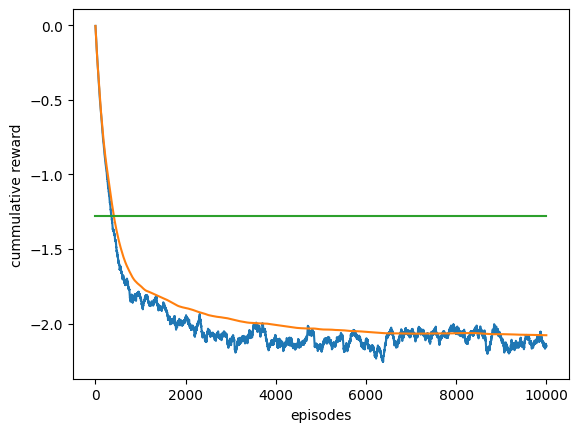

In [762]:
media_tempo_td = np.cumsum(Vs_td)/(np.arange(N)+1)
media_tempo_mc = np.cumsum(Vs_mc)/(np.arange(N)+1)
plt.plot(Vs_td)
plt.plot(media_tempo_mc)
plt.plot([1,N],[v_VI[grid.states[-1]], v_VI[grid.states[-1]]])
plt.ylabel('acummulative reward')
plt.xlabel('episodes')
plt.show()

## Q-Learning

In [773]:
def QLearning(Qsa, grid: Traffic_Enviroment, alpha, gamma, maxSteps):
    count_goal = []
    last_goal = 0
    rewards = []

    for i in range(maxSteps):
        s = grid.state
        g = grid.count_zeros(list(s[:-1]))
        if g >= grid.goal:
            grid.reset()
            count_goal = count_goal + [i - last_goal]
            last_goal = i
            rewards = rewards + [0]
            continue

        if random.random() < epsilon:
            a = random.choice(grid.actions)
        else:
            a = max(Qsa[s], key=Qsa[s].get)

        ss, r = grid.step(a)
        rewards = rewards + [r]

        Qsa[s][a] = Qsa[s][a] + alpha * (r + gamma * max(Qsa[ss].values()) - Qsa[s][a])

    return Qsa, rewards, count_goal

In [774]:
tempo = .25

epsilon = 0.005
alpha = 0.01
gamma = 1


grid = Traffic_Enviroment(5,5)
maxSteps = 100000


# Inicializa valores

Qa = {}
for a in grid.actions:
    Qa[a] = 0


Qsa = {}
for s in grid.states:
    Qsa[s] = Qa.copy()


Qsa, rewards, count_goal = QLearning(Qsa,grid,alpha,gamma,maxSteps)

print(len(count_goal))

8375


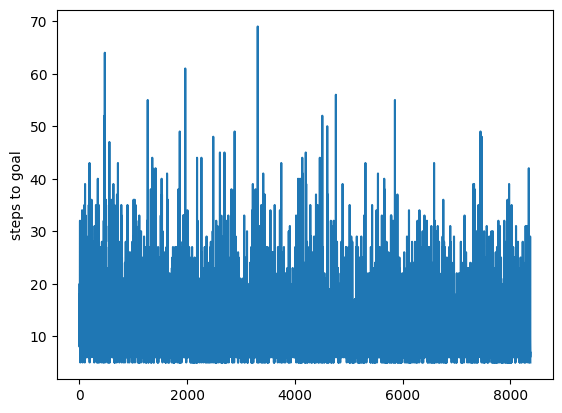

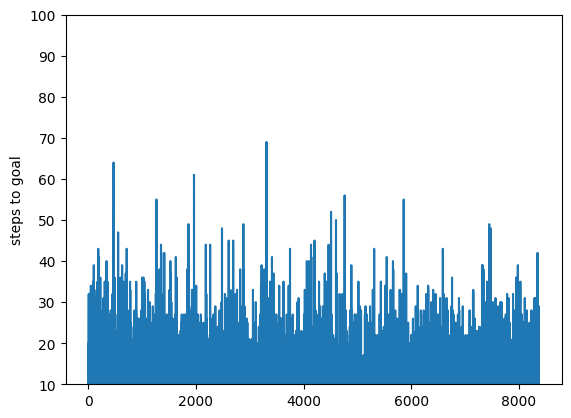

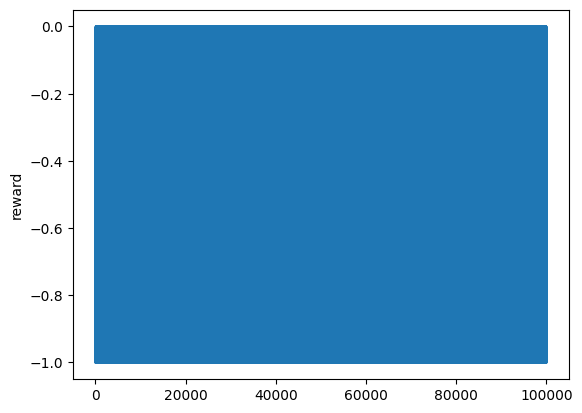

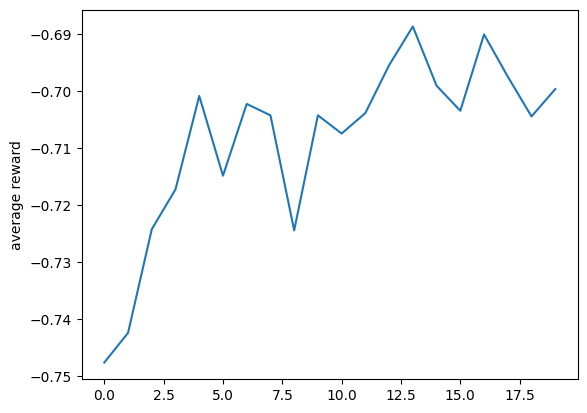

In [775]:
plt.plot(range(len(count_goal)),count_goal)
plt.ylabel('steps to goal')
plt.show()

plt.plot(range(len(count_goal)),count_goal)
plt.ylabel('steps to goal')
plt.ylim(10,100)
plt.show()


plt.plot(rewards)
plt.ylabel('reward')
plt.show()


data = np.array(rewards).reshape((20,-1))
plt.plot(np.mean(data,axis=1))
plt.ylabel('average reward')
plt.show()